## House Price Prediction
# Overview
This project predicts house prices using the Ames Housing Dataset. A Random Forest model was trained and deployed as a Streamlit web app to allow users to input features and get price predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import joblib

In [3]:
# Load dataset
df = pd.read_csv('train.csv')
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

## Dataset
- Source: Ames Housing Dataset from Kaggle (House Prices - Advanced Regression Techniques).
- Shape: (1460, 81)
- Target: SalePrice (continuous, in USD).
- Key Features: OverallQual, GrLivArea, TotalBsmtSF, GarageArea, LotArea, Neighborhood, BldgType, HouseStyle, MSZoning.
- Missing Values: High in PoolQC (1453), MiscFeature (1406), Alley (1369), Fence (1179), MasVnrType (872).

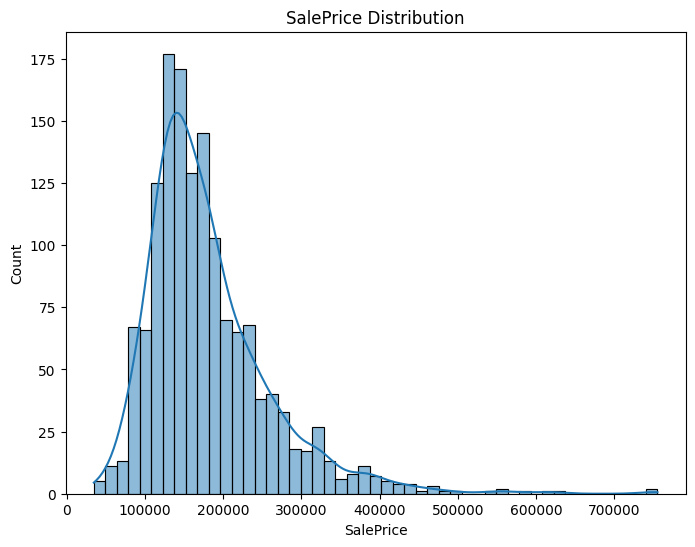

In [4]:
# SalePrice distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['SalePrice'], kde=True)
plt.title('SalePrice Distribution')
plt.show()

In [5]:
# Numerical and categorical columns
num_cols = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'OverallQual']
cat_cols = ['Neighborhood', 'BldgType', 'HouseStyle', 'MSZoning']

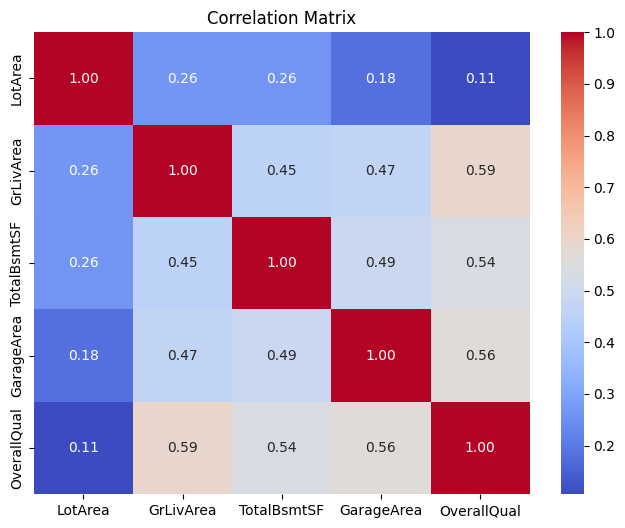

In [6]:
# Correlation matrix for numerical features
corr = df[num_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [7]:
# Top 5 correlations with SalePrice
print("Top 5 Correlations with SalePrice:\n", df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False).head(6))

Top 5 Correlations with SalePrice:
 SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64


## Exploratory Data Analysis (EDA)
- Visualized SalePrice distribution (right-skewed, mean: ~$180,921, max: $755,000).
- Computed correlations to identify key predictors.
- Top 5 correlations with SalePrice:
- SalePrice: 1.000000
- OverallQual: 0.790982
- GrLivArea: 0.708624
- GarageCars: 0.640409
- GarageArea: 0.623431
- TotalBsmtSF: 0.613581

In [8]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
    ]
)

## Preprocessing
Features:
- Numerical: LotArea, GrLivArea, TotalBsmtSF, GarageArea, OverallQual (imputed with median, scaled with StandardScaler).
- Categorical: Neighborhood, BldgType, HouseStyle, MSZoning (one-hot encoded with OneHotEncoder).
- Pipeline: Used ColumnTransformer to handle numerical and categorical features.
- Data Split: 80% train (1168 rows), 20% test (292 rows).
- Shape Fix: Adjusted test set features to match training set (44 features).

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)
print(X_test_pre.shape)

(292, 44)


In [10]:
# Fix test set shape
if X_test_pre.shape[1] != X_train_pre.shape[1]:
    feature_names = preprocessor.get_feature_names_out()
    missing_cols = set(feature_names) - set(preprocessor.get_feature_names_out(X_test.columns))
    missing_cols_idx = [list(feature_names).index(col) for col in missing_cols]
    for idx in missing_cols_idx:
        X_test_pre = np.insert(X_test_pre, idx, 0, axis=1)
    print("X_test_pre shape (after fix):", X_test_pre.shape)
else:
    print("X_test_pre shape:", X_test_pre.shape)

X_test_pre shape: (292, 44)


## Model Training
- Model: Random Forest Regressor (random_state=42).
- Features Used: 5 numerical, 4 categorical (44 features after encoding).
- Saved: Model (house_price_model.pkl) and preprocessor (preprocessor.pkl).

In [11]:
# Train Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_pre, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Evaluation
- Metrics:
- RMSE: $29,194.74
- R2: 0.89
- Feature Importance:
- OverallQual: 0.588257
- GrLivArea: 0.178465
- TotalBsmtSF: 0.091544
- GarageArea: 0.049498
- LotArea: 0.042763
- Visualized predicted vs. actual SalePrice and feature importance.

In [12]:
# Save updated model and preprocessor
joblib.dump(rf, 'house_price_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

In [13]:
# Verify shapes
print("X_train_pre shape:", X_train_pre.shape)
print("X_test_pre shape:", X_test_pre.shape)

X_train_pre shape: (1168, 44)
X_test_pre shape: (292, 44)
